In [1]:
from cmath import sqrt
import numpy as np
from numpy import linalg as LA
from scipy.linalg import lu, svd,schur,qr
import sklearn.datasets as data
import time
import matplotlib.pylab as plt
import os
import sklearn
from scipy.sparse import random
from pathlib import Path

In [2]:
def spd_matrix(n, sparsity = None, *args):
    """ Creates sparse or dense Positive Definite matrix
        
        Since Levy–Desplanques theorem proved that a strictly diagonally dominant matrix is non-singular.
        
        args:
            dim : int, default=1
                The size of the random matrix to generate.
    
            alpha : float, default=0.95
                The probability that a coefficient is zero. Larger values enforce more sparsity.
                The value should be in the range 0 and 1.
    
            norm_diag :bool, default=False
                    Whether to normalize the output matrix to make the leading diagonal elements all 1

            smallest_coef :float, default=0.1
                        The value of the smallest coefficient between 0 and 1.

            largest_coef :float, default=0.9
                        The value of the largest coefficient between 0 and 1.

            random_state :int, RandomState instance or None, default=None
                        Determines random number generation for dataset creation. 
                        Pass an int for reproducible output across multiple function calls.
            
        returns:
            array: semi positive definite n x n dimansional matrix and sparsity rate the matrix
        
        Possible Error : 
            When the dimansion of the matrix increase; the alpha should be increased as well however,
            above 600 x 600 matrix dimansion (emprically since sklearn uses randomization) yields to generating non-spd matrix.
        
    """
    
    #if sparsity :
    A = data.make_sparse_spd_matrix(dim = n, alpha = sparsity, norm_diag = False, 
                                    smallest_coef = 0.1, largest_coef = 0.9, random_state = None)
        
        
   # else:
        #A = data.make_spd_matrix(n, *args)
        #print("dense")
          
    return A

def identity_matrix(n):
    Matrix = np.identity(n)
    return Matrix

def random_matrix(n):
    Matrix = np.random.rand(n,n)
    return Matrix

def random_sparse_matrix(n,sparsity):
    Matrix = random(n,n,density=sparsity)
    return Matrix.A

def pos_semidef_check (x):
    " Check if all eigen values are nonnegative "
    
    w,v = np.linalg.eig(x)
    
    #print("Eigenvalues :",w)
    #print("Eigenvectors :", v)
    return np.all(w >= 0)
    
def custom_cholesky (A):
    """ Cholesky algorithm for decomposition of a SPD matrix, returns lower triangular matrix """
    
    check = pos_semidef_check(A) and symmetry_check(A)
    
    if check == True:
        
        L = np.zeros_like(A, dtype = float) # without dtype = float it introduces rounding error
        n = len(A)

    # Perform the Cholesky decomposition
        for i in range(n):
            for k in range(i+1):
                tmp_sum = sum(L[i][j] * L[k][j] for j in range(k))
                
                if (i == k): # Diagonal elements
                # l_{kk} = \sqrt{ a_{kk} - \sum^{k-1}_{j=1} l^2_{kj}}
                    
                    L[i][k] = abs(sqrt(A[i][i] - tmp_sum))
                else:
                # l_{ik} = \frac{1}{l_{kk}} \left( a_{ik} - \sum^{k-1}_{j=1} l_{ij} l_{kj} \right)
                    L[i][k] = abs((A[i][k] - tmp_sum) / L[k][k])
        return L
        
    else:
        return f" Check fails "
    
def numpy_cholesky(A) :
    return np.linalg.cholesky(A)

def scipy_lu(A) :
    return lu(A)

def numpy_spectral(A) :
    return np.linalg.eig(A)

def scipy_svd(A) :
    return svd(A)

def scipy_schur(A) :
    return schur(A)

def scipy_qr(A) :    
    return qr(A)


In [ ]:
class TEST():
    def __init__(self, mtrx, fact, typ, dim, test_run, sparsity = 0.0, *args):
        """ Class to test how different algorithms perform factorization process
        
             By the help of passed different combination of variables and methods, this claass test
             the performance of algorithms, saves the results in a npy file and read it back
             
            Args:
                mtrx: str, matrix type to use e.g "spd" creates Positive Definite matrix
                    
                    
                fact: str, factorization algorithm to use e.g. "cholesky" 
                
                typ: str, specific factorization algorhm to use e.g. "numpy" returns the factorization 
                    method from that library
                     
                dim: int, dimantionality of the square matrix 
                    Possible change : we may change this argument as tuple to create 
                    non-square matrices for different applications
                     
                est_run: int, for every dimansion step we run the factorization algorithms this varible times
                     
            Returns:
                results: array, averaged test results for every dimantion of the matrix
            
        """
        
        self.matrix = {"spd" : spd_matrix, "random" : random_matrix,
                       "identity" : identity_matrix,"random_sparse" : random_sparse_matrix }
        
        self.factorization = { 
                    "cholesky" : {"custom" : custom_cholesky, "numpy" : numpy_cholesky},
                    "lu" : {"scipy" : scipy_lu},
                    "spectral" : {"numpy" : numpy_spectral},
                    "svd" : {"scipy" : scipy_svd},
                    "schur" : {"scipy" : scipy_schur},
                    "qr" : {"scipy" : scipy_qr}, 
        }
        
        self.dim = dim
        self.test_run = test_run
        self.typ = typ
        self.fact = fact
        self.mtrx = mtrx
        self.sparsity = sparsity
        
    def stochastic_test(self):
        results = []
        
        
        for j in range(1,self.dim+1):
            if(self.mtrx=="spd" or self.mtrx=="random_sparse"): 
                self.A = self.matrix[self.mtrx](j, self.sparsity)
            else:    
                self.A = self.matrix[self.mtrx](j)
            self.rate = TEST.get_sparsity(self, self.A,j)
            
            t = 0
            for i in range(self.test_run):
                
                t_0 = time.time()
                L = self.factorization[self.fact][self.typ](self.A)
                t_1 = time.time() 
                a = t_1 - t_0
                t = t + a     
                
            T = t / self.test_run
            results.append([j, T, self.rate])
            
        TEST.save_file(self, results, self.rate)
            
        plt.title("Sparsity Scheme of Main Matrix")
        plt.spy(self.A)
        
        return results
        
    def get_sparsity(self, m,b):
        self.mat = m
        n = b     #dimension
        sparsity_rate = self.mat[np.where(self.mat == 0)].size / (n*n)
        
        return sparsity_rate
            
    def save_file(self, results, rate):
        self.current_dir = os.getcwd()
        self.new_dir = self.current_dir+"\\Result"+"\\"+self.fact
        self.results = results
        self.rate = str("{:.4f}".format(rate))
        
        try : 
            os.makedirs(self.new_dir)
        except OSError as error:
            pass

        outfile = (self.typ+"_"+self.fact+"_"+self.mtrx+"_"
                   +str(self.dim)+"dim"+"_"+str(self.test_run)
                   +"run"+"_"+self.rate+"sparsity")
        
        out_path = self.new_dir+"\\"+outfile
                
        return np.save(out_path, self.results, allow_pickle=True, fix_imports=True)

In [ ]:
t= TEST("random_sparse","schur", "scipy", 55, 10,0.5)
t.stochastic_test()
print("done")

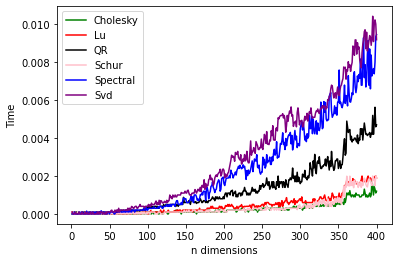

In [71]:
"""Using identity matrix from 1x1 to 400x400""" 
resource1 = np.load(os.getcwd() + "\\Result\\cholesky\\numpy_cholesky_identity_400dim_10run_0.9975sparsity.npy")
resource2 = np.load(os.getcwd() + "\\Result\\lu\\scipy_lu_identity_400dim_10run_0.9975sparsity.npy")
resource3 = np.load(os.getcwd() + "\\Result\\qr\\scipy_qr_identity_400dim_10run_0.9975sparsity.npy")
resource4 = np.load(os.getcwd() + "\\Result\\schur\\scipy_schur_identity_400dim_10run_0.9975sparsity.npy")
resource5 = np.load(os.getcwd() + "\\Result\\spectral\\numpy_spectral_identity_400dim_10run_0.9975sparsity.npy")
resource6 = np.load(os.getcwd() + "\\Result\\svd\\scipy_svd_identity_400dim_10run_0.9975sparsity.npy")
########################################################################


plt.plot(resource1[:,0], resource1[:,1], label='Cholesky', color='green')
plt.plot(resource2[:,0], resource2[:,1], label='Lu', color='red')
plt.plot(resource3[:,0], resource3[:,1], label='QR', color='black')
plt.plot(resource4[:,0], resource4[:,1], label='Schur', color='pink')
plt.plot(resource5[:,0], resource5[:,1], label='Spectral', color='blue')
plt.plot(resource6[:,0], resource6[:,1], label='Svd', color='purple')
########################################################################

plt.xlabel('n dimensions')
plt.ylabel('Time')

plt.legend()
plt.show()

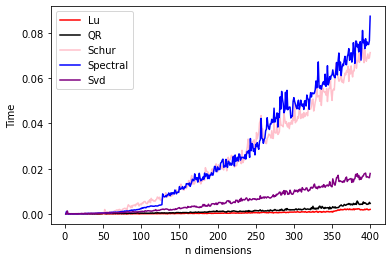

In [72]:
"""Using random value matrix from 1x1 to 400x400 (value from 0~1)""" 
resource2 = np.load(os.getcwd() + "\\Result\\lu\\scipy_lu_random_400dim_10run_0.0sparsity.npy")
resource3 = np.load(os.getcwd() + "\\Result\\qr\\scipy_qr_random_400dim_10run_0.0sparsity.npy")
resource4 = np.load(os.getcwd() + "\\Result\\schur\\scipy_schur_random_400dim_10run_0.0sparsity.npy")
resource5 = np.load(os.getcwd() + "\\Result\\spectral\\numpy_spectral_random_400dim_10run_0.0sparsity.npy")
resource6 = np.load(os.getcwd() + "\\Result\\svd\\scipy_svd_random_400dim_10run_0.0sparsity.npy")
########################################################################



plt.plot(resource2[:,0], resource2[:,1], label='Lu', color='red')
plt.plot(resource3[:,0], resource3[:,1], label='QR', color='black')
plt.plot(resource4[:,0], resource4[:,1], label='Schur', color='pink')
plt.plot(resource5[:,0], resource5[:,1], label='Spectral', color='blue')
plt.plot(resource6[:,0], resource6[:,1], label='Svd', color='purple')
########################################################################

plt.xlabel('n dimensions')
plt.ylabel('Time')

plt.legend()
plt.show()

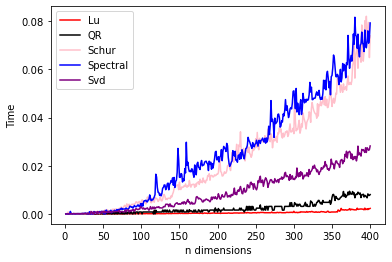

In [73]:
"""Using spd matrix from 1x1 to 400x400 (alpha =0.9)""" 

resource12 = np.load(os.getcwd() + "\\Result\\lu\\scipy_lu_spd_400dim_10run_0.3307375sparsity.npy")
resource13 = np.load(os.getcwd() + "\\Result\\qr\\scipy_qr_spd_400dim_10run_0.3345375sparsity.npy")
resource14 = np.load(os.getcwd() + "\\Result\\schur\\scipy_schur_spd_400dim_10run_0.3514375sparsity.npy")
resource15 = np.load(os.getcwd() + "\\Result\\spectral\\numpy_spectral_spd_400dim_10run_0.34365sparsity.npy")
resource16 = np.load(os.getcwd() + "\\Result\\svd\\scipy_svd_spd_400dim_10run_0.349225sparsity.npy")
########################################################################



plt.plot(resource12[:,0], resource12[:,1], label='Lu', color='red')
plt.plot(resource13[:,0], resource13[:,1], label='QR', color='black')
plt.plot(resource14[:,0], resource14[:,1], label='Schur', color='pink')
plt.plot(resource15[:,0], resource15[:,1], label='Spectral', color='blue')
plt.plot(resource16[:,0], resource16[:,1], label='Svd', color='purple')
########################################################################

plt.xlabel('n dimensions')
plt.ylabel('Time')

plt.legend()
plt.show()

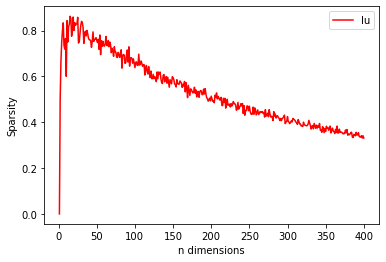

In [62]:
"""Using spd matrix from 1x1 to 400x400 (alpha =0.9)""" 

resource12 = np.load(os.getcwd() + "\\Result\\lu\\scipy_lu_spd_400dim_10run_0.3307375sparsity.npy")
########################################################################



plt.plot(resource12[:,0], resource12[:,2], label='lu', color='red')
########################################################################

plt.xlabel('n dimensions')
plt.ylabel('Sparsity')

plt.legend()
plt.show()

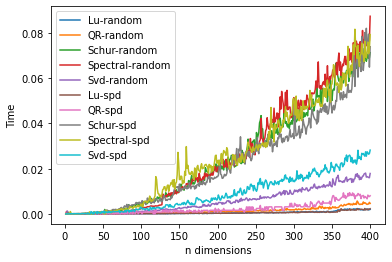

In [76]:
plt.plot(resource2[:,0], resource2[:,1], label='Lu-random')
plt.plot(resource3[:,0], resource3[:,1], label='QR-random')
plt.plot(resource4[:,0], resource4[:,1], label='Schur-random')
plt.plot(resource5[:,0], resource5[:,1], label='Spectral-random')
plt.plot(resource6[:,0], resource6[:,1], label='Svd-random',)
########################################################################
plt.plot(resource12[:,0], resource12[:,1], label='Lu-spd')
plt.plot(resource13[:,0], resource13[:,1], label='QR-spd')
plt.plot(resource14[:,0], resource14[:,1], label='Schur-spd')
plt.plot(resource15[:,0], resource15[:,1], label='Spectral-spd')
plt.plot(resource16[:,0], resource16[:,1], label='Svd-spd')
########################################################################

plt.xlabel('n dimensions')
plt.ylabel('Time')

plt.legend()
plt.show()

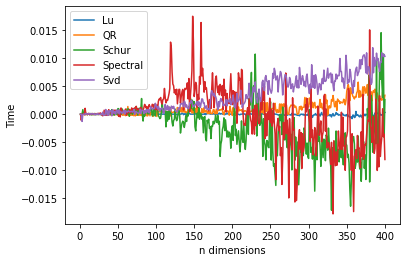

In [75]:
"""Compare spd matrix and random value matrix from 1x1 to 400x400 """ 
Compare_lu = resource2.copy()
Compare_qr = resource3.copy()
Compare_schur = resource4.copy()
Compare_spectral = resource5.copy()
Compare_svd = resource6.copy()


Compare_lu[:,1] = resource12[:,1] - resource2[:,1]
Compare_qr[:,1] = resource13[:,1] - resource3[:,1]
Compare_schur[:,1] = resource14[:,1] - resource4[:,1]
Compare_spectral[:,1] = resource15[:,1] - resource5[:,1]
Compare_svd[:,1] = resource16[:,1] - resource6[:,1]

plt.plot(Compare_lu[:,0],       Compare_lu[:,1], label='Lu')
plt.plot(Compare_qr[:,0],       Compare_qr[:,1], label='QR')
plt.plot(Compare_schur[:,0],    Compare_schur[:,1], label='Schur')
plt.plot(Compare_spectral[:,0], Compare_spectral[:,1], label='Spectral')
plt.plot(Compare_svd[:,0],      Compare_svd[:,1], label='Svd')
plt.xlabel('n dimensions')
plt.ylabel('Time')

plt.legend()
plt.show()

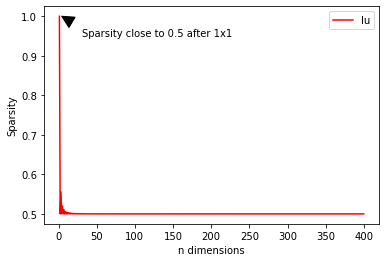

In [74]:
"""sparsity 0.5"""
resource22 = np.load(os.getcwd() + "\\Result\\lu\\scipy_lu_random_sparse_400dim_10run_0.5sparsity.npy")
plt.plot(resource22[:,0], resource22[:,2], label='lu', color='red')
plt.xlabel('n dimensions')
plt.ylabel('Sparsity')
plt.annotate('Sparsity close to 0.5 after 1x1', xy=(4, 1), xytext=(30, 0.95),
             arrowprops=dict(facecolor='black', shrink=0.5))
plt.legend()
plt.show()